In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

import datetime

from arch import arch_model
import wrds

import numpy.linalg as la
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt

from collections import defaultdict

from joblib import Parallel, delayed

from tqdm import tqdm
import seaborn as sns

In [5]:
df = pd.read_csv("final_dataset_backtest.csv")
df

,date,permno,ticker,prc,retx,shrout,cfacpr,vol,vwretd,vwretx,...,ou_forecast_20d,z_score_20d,fed_funds_rate,actual_vol_1d_lag1,actual_vol_5d,actual_vol_5d_lag1,actual_vol_10d,actual_vol_10d_lag1,actual_vol_20d,actual_vol_20d_lag1
0,1986-04-01,10008,GACO,-18.50,0.042254,2945.0,1.0,47.95,-0.011717,-0.011773,...,NaN,0.000000,7.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1986-04-02,10008,GACO,-18.00,-0.027027,2945.0,1.0,231.00,0.001289,0.001186,...,-0.002341,0.000000,7.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1986-04-03,10008,GACO,-18.25,0.013889,2945.0,1.0,3.50,-0.009560,-0.009571,...,-0.002341,0.000000,7.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1986-04-04,10008,GACO,-18.25,0.000000,2945.0,1.0,39.50,-0.013887,-0.014239,...,-0.002341,0.000000,6.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1986-04-07,10008,GACO,-18.25,0.000000,2945.0,1.0,68.00,-0.002678,-0.002752,...,-0.002341,0.000000,7.09,NaN,0.056338,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14686923,2024-12-24,93436,TSLA,462.28,0.073572,3210060.0,1.0,593515.06,0.010566,0.010521,...,0.001722,-0.114998,4.33,NaN,0.131718,0.106439,0.157805,0.145334,0.170305,0.167895
14686924,2024-12-26,93436,TSLA,454.13,-0.017630,3210060.0,1.0,763922.73,0.000346,0.000282,...,0.001722,-0.317544,4.33,NaN,0.095352,0.131718,0.152724,0.157805,0.172878,0.170305
14686925,2024-12-27,93436,TSLA,431.66,-0.049479,3210060.0,1.0,823703.45,-0.010692,-0.010775,...,0.001722,0.117134,4.33,NaN,0.111126,0.095352,0.161946,0.152724,0.182332,0.172878
14686926,2024-12-30,93436,TSLA,417.41,-0.033012,3210060.0,1.0,647054.52,-0.009878,-0.009900,...,0.001722,0.186010,4.33,NaN,0.110521,0.111126,0.159511,0.161946,0.186401,0.182332


In [6]:
df.isnull().sum()

date                                  0
permno                                0
ticker                             1346
prc                                   0
retx                                  0
shrout                                0
cfacpr                                0
vol                                   0
vwretd                                0
vwretx                                0
trading_start                         0
group_id                              0
group_avg_retx                        0
retx_relative                         0
retx_relative_lag1                12448
group_std_retx_relative_1d     14686928
z_score_classic_1d                    0
z_score_classic_1d_lag1               0
group_std_retx_relative_5d            0
z_score_classic_5d                    0
z_score_classic_5d_lag1               0
group_std_retx_relative_10d           0
z_score_classic_10d                   0
z_score_classic_10d_lag1              0
group_std_retx_relative_20d           0


In [7]:
df.shape

(14686928, 49)

In [8]:
df['group_std_retx_relative_1d'] = (
    df.groupby(['date', 'group_id'])['retx_relative']
      .transform('std')
)
df['adj_prc'] = df['prc'] / df['cfacpr']
df.isnull().sum()

date                                  0
permno                                0
ticker                             1346
prc                                   0
retx                                  0
shrout                                0
cfacpr                                0
vol                                   0
vwretd                                0
vwretx                                0
trading_start                         0
group_id                              0
group_avg_retx                        0
retx_relative                         0
retx_relative_lag1                12448
group_std_retx_relative_1d            0
z_score_classic_1d                    0
z_score_classic_1d_lag1               0
group_std_retx_relative_5d            0
z_score_classic_5d                    0
z_score_classic_5d_lag1               0
group_std_retx_relative_10d           0
z_score_classic_10d                   0
z_score_classic_10d_lag1              0
group_std_retx_relative_20d           0


In [9]:
def add_actual_volatility(df):
    """
    Adds realized (historical) volatility over multiple time horizons: 1, 5, 10, and 20 days.
    """
    horizons = [1, 5, 10, 20]
    df = df.sort_values(['permno', 'date']).copy()

    for horizon in horizons:
        vol_col = f'actual_vol_{horizon}d'
        vol_lag_col = f'{vol_col}_lag1'

        # For 1-day volatility, std is always NaN (you need at least 2 points). Set it to 0 explicitly or skip.
        if horizon == 1:
            df[vol_col] = np.nan  # Volatility over 1 day doesn't make sense statistically.
        else:
            min_p = max(2, horizon // 2)
            df[vol_col] = (
                df.groupby('permno')['retx']
                  .rolling(window=horizon, min_periods=min_p)
                  .std()
                  .reset_index(level=0, drop=True)
            )

        df[vol_lag_col] = df.groupby('permno')[vol_col].shift(1)

    return df

df = add_actual_volatility(df)
df.isnull().sum()

date                                  0
permno                                0
ticker                             1346
prc                                   0
retx                                  0
shrout                                0
cfacpr                                0
vol                                   0
vwretd                                0
vwretx                                0
trading_start                         0
group_id                              0
group_avg_retx                        0
retx_relative                         0
retx_relative_lag1                12448
group_std_retx_relative_1d            0
z_score_classic_1d                    0
z_score_classic_1d_lag1               0
group_std_retx_relative_5d            0
z_score_classic_5d                    0
z_score_classic_5d_lag1               0
group_std_retx_relative_10d           0
z_score_classic_10d                   0
z_score_classic_10d_lag1              0
group_std_retx_relative_20d           0


In [10]:
def compute_group_std_correct(df, horizon):
    return (
        df.groupby(['group_id'])
          .apply(lambda group: group.sort_values('date')
                                  .assign(**{f'group_std_retx_relative_{horizon}d': 
                                              group['retx_relative'].shift(1).rolling(window=horizon, min_periods=1).std()}))
          .reset_index(drop=True)
    )


# Now you can call:
df = compute_group_std_correct(df, horizon=5)
df.isnull().sum()

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1085/2550445080.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sort_values('date')


date                                  0
permno                                0
ticker                             1346
prc                                   0
retx                                  0
shrout                                0
cfacpr                                0
vol                                   0
vwretd                                0
vwretx                                0
trading_start                         0
group_id                              0
group_avg_retx                        0
retx_relative                         0
retx_relative_lag1                12448
group_std_retx_relative_1d            0
z_score_classic_1d                    0
z_score_classic_1d_lag1               0
group_std_retx_relative_5d         2896
z_score_classic_5d                    0
z_score_classic_5d_lag1               0
group_std_retx_relative_10d           0
z_score_classic_10d                   0
z_score_classic_10d_lag1              0
group_std_retx_relative_20d           0


In [8]:
correlation_matrix = df[['retx', 'garch_vol_5d_lag1', 'ou_forecast_5d', 'z_score_5d', 
                         'actual_vol_5d', 'retx_relative_lag1', 'group_std_retx_relative_5d', 'adj_prc']].corr()
print(correlation_matrix)


                                retx  garch_vol_5d_lag1  ou_forecast_5d  \
retx                        1.000000           0.013014        0.030155   
garch_vol_5d_lag1           0.013014           1.000000        0.096858   
ou_forecast_5d              0.030155           0.096858        1.000000   
z_score_5d                  0.041097          -0.006065       -0.131908   
actual_vol_5d               0.110834           0.726949        0.074802   
retx_relative_lag1         -0.076235           0.020099        0.188360   
group_std_retx_relative_5d  0.014954           0.732280        0.067952   
adj_prc                     0.000999           0.016994       -0.006501   

                            z_score_5d  actual_vol_5d  retx_relative_lag1  \
retx                          0.041097       0.110834           -0.076235   
garch_vol_5d_lag1            -0.006065       0.726949            0.020099   
ou_forecast_5d               -0.131908       0.074802            0.188360   
z_score_5d      

In [9]:
horizons = [1, 5, 10, 20]

for h in horizons:
    df[f'future_return_{h}d'] = (
        df.groupby('permno')['retx']
          .transform(lambda x: x.shift(-h).rolling(h).sum())
    )
def evaluate_signal(df, horizon):
    z_col = f'z_score_{horizon}d'
    future_return_col = f'future_return_{horizon}d'
    
    # Drop missing data for evaluation
    valid_data = df[[z_col, future_return_col]].dropna()
    
    # Directional Accuracy (Are signals pointing the right way?)
    correct_direction = np.sign(valid_data[z_col]) == np.sign(valid_data[future_return_col])
    accuracy = correct_direction.mean()
    
    # Correlation
    corr = valid_data[z_col].corr(valid_data[future_return_col])
    
    # Return average future returns for high z-scores
    high_signal = valid_data[np.abs(valid_data[z_col]) >= 1.5]  # Strong signals
    avg_return_high_signal = high_signal[future_return_col].mean()
    
    return accuracy, corr, avg_return_high_signal

# Run Evaluation for All Horizons
for h in horizons:
    acc, corr, avg_ret = evaluate_signal(df, h)
    print(f"\n📈 Horizon: {h} Days")
    print(f"✔️ Direction Accuracy: {acc:.2%}")
    print(f"🔗 Correlation: {corr:.4f}")
    print(f"💰 Avg. Future Return (|Z| ≥ 1.5): {avg_ret:.4f}")


📈 Horizon: 1 Days
✔️ Direction Accuracy: 43.85%
🔗 Correlation: 0.0102
💰 Avg. Future Return (|Z| ≥ 1.5): 0.0013

📈 Horizon: 5 Days
✔️ Direction Accuracy: 49.75%
🔗 Correlation: 0.0173
💰 Avg. Future Return (|Z| ≥ 1.5): 0.0031

📈 Horizon: 10 Days
✔️ Direction Accuracy: 50.29%
🔗 Correlation: 0.0177
💰 Avg. Future Return (|Z| ≥ 1.5): 0.0064

📈 Horizon: 20 Days
✔️ Direction Accuracy: 50.54%
🔗 Correlation: 0.0155
💰 Avg. Future Return (|Z| ≥ 1.5): 0.0136


In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
def plot_vol_and_return_analysis(df, ticker, horizon=5, start_year=None):
    df_ticker = df[df['ticker'] == ticker].sort_values('date')
    if start_year:
        df_ticker = df_ticker[df_ticker['date'].dt.year >= start_year]

    if df_ticker.empty:
        print(f"No data found for ticker '{ticker}' after filtering.")
        return
    
    plt.figure(figsize=(14, 6))

    # Plot Actual vs Predicted Volatility
    plt.subplot(1, 2, 1)
    plt.plot(df_ticker['date'], df_ticker[f'actual_vol_{horizon}d_lag1'], label='Actual Volatility')
    plt.plot(df_ticker['date'], df_ticker[f'garch_vol_{horizon}d_lag1'], label='GARCH Predicted')
    plt.title(f'{ticker} - Volatility ({horizon}D Horizon)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)

    # Plot Z-Score vs. Future Returns
    plt.subplot(1, 2, 2)
    plt.scatter(df_ticker[f'z_score_{horizon}d'], df_ticker[f'future_return_{horizon}d'], alpha=0.3)
    plt.axhline(0, color='black', linestyle='--')
    plt.axvline(0, color='black', linestyle='--')
    plt.title(f'{ticker} - Z-Score vs Future Return ({horizon}D)')
    plt.xlabel('Z-Score')
    plt.ylabel('Future Return')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


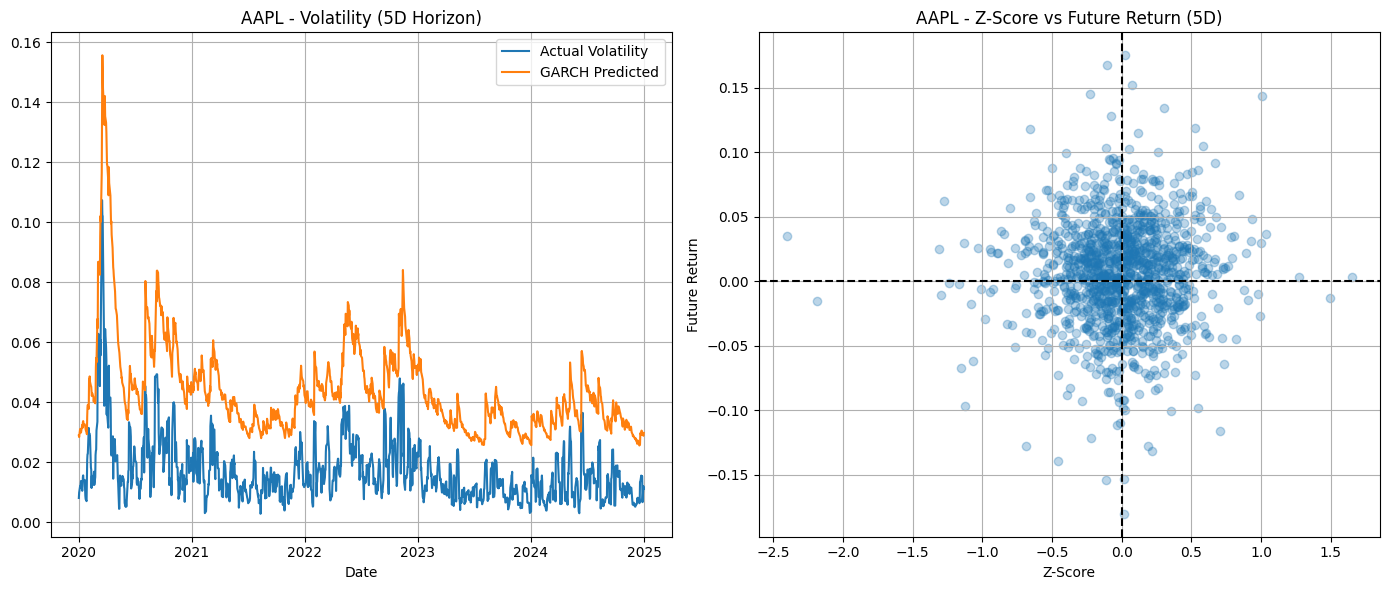

In [12]:
plot_vol_and_return_analysis(df, ticker='AAPL', horizon=5, start_year=2020)


In [13]:
# Example Run
df = df.sort_values('date')

In [29]:
def prepare_trade_data_bef(df, z_score_col='z_score_5d'):
    """
    Prepares and cleans the DataFrame for backtesting by removing rows with NaNs 
    in critical trading columns.

    Parameters:
    - df: Raw DataFrame.
    - z_score_col: The Z-Score column to use for trading signals.

    Returns:
    - Cleaned DataFrame ready for backtest.
    """
    required_cols = ['date', 'permno', 'group_id', 'adj_prc', z_score_col]

    # Validate required columns exist
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Remove rows with NaNs in required columns
    df_clean = df.dropna(subset=required_cols).copy()

    # Ensure 'date' column is datetime type
    if not pd.api.types.is_datetime64_any_dtype(df_clean['date']):
        df_clean['date'] = pd.to_datetime(df_clean['date'])

    return df_clean

## Mean reversion

In [ ]:
def get_daily_groups(df, z_score_col):
    required_cols = ['permno', 'group_id', 'adj_prc', 'date', z_score_col]
    if z_score_col not in df.columns:
        raise ValueError(f"Column '{z_score_col}' not found in DataFrame.")
    df = df.dropna(subset=required_cols)
    return dict(tuple(df.groupby('date')))

def trade_signal(z_score, threshold=1.5):
    if z_score <= -threshold:
        return 'Long'
    elif z_score >= threshold:
        return 'Short'
    return None

def exit_signal(z_score, side):
    return (side == 'Long' and z_score >= 0) or (side == 'Short' and z_score <= 0)

def backtest(df, z_score_col='z_score_5d', investment_per_trade=1_000_000, z_threshold=1.5):
    df = df.sort_values('date')
    daily_groups = get_daily_groups(df, z_score_col)
    unique_dates = sorted(daily_groups.keys())

    open_positions = {}
    trade_log = []

    for date in tqdm(unique_dates):
        day_data = daily_groups[date].set_index('permno')

        # Exit Logic
        exiting_permnso = [permno for permno in open_positions if permno in day_data.index]
        for permno in exiting_permnso:
            row = day_data.loc[permno]
            z = row[z_score_col]
            pos = open_positions[permno]

            if exit_signal(z, pos['side']):
                exit_price = row.adj_prc
                shares = pos['shares']
                investment = pos['investment']
                total_return = shares * exit_price - investment if pos['side'] == 'Long' else investment - shares * exit_price

                trade_log.append({
                    'entry_date': pos['entry_date'], 'exit_date': date,
                    'permno': permno, 'group_id': pos['group_id'], 'side': pos['side'],
                    'entry_price': pos['entry_price'], 'exit_price': exit_price,
                    'shares': shares, 'investment': investment,
                    'total_return': total_return
                })
                del open_positions[permno]

        # Entry Logic
        for permno, row in day_data.iterrows():
            if permno in open_positions:
                continue
            z = row[z_score_col]
            signal = trade_signal(z, z_threshold)
            if not signal:
                continue
            price = row.adj_prc
            shares = int(investment_per_trade / price)
            if shares <= 0:
                continue

            open_positions[permno] = {
                'entry_date': date, 'group_id': row.group_id,
                'entry_price': price, 'shares': shares,
                'investment': shares * price, 'side': signal
            }

    return pd.DataFrame(trade_log)

In [33]:
def trade_summary(trades: pd.DataFrame, annual_interest_rate=0.065, transaction_cost_per_trade=0.1, trading_days=252, risk_free_rate=0.0):
    if trades.empty:
        print("No trades to summarize.")
        return pd.DataFrame()

    trades = trades.copy()
    trades['entry_year'] = pd.to_datetime(trades['entry_date']).dt.year
    trades['exit_year'] = pd.to_datetime(trades['exit_date']).dt.year
    trades['holding_days'] = (pd.to_datetime(trades['exit_date']) - pd.to_datetime(trades['entry_date'])).dt.days.clip(lower=1)

    # Pre-calculate Costs
    daily_rate = annual_interest_rate / trading_days
    trades['financing_cost'] = trades['investment'] * daily_rate * trades['holding_days']
    trades['transaction_cost'] = transaction_cost_per_trade * 2  # Entry + Exit
    trades['total_cost'] = trades['financing_cost'] + trades['transaction_cost']
    trades['net_return'] = trades['total_return'] - trades['total_cost']
    trades['annualized_return'] = (trades['total_return'] / trades['investment']) * (trading_days / trades['holding_days'])

    # Group by Exit Year and Aggregate
    grouped = trades.groupby('exit_year')
    
    summary = grouped.agg(
        num_trades=('permno', 'count'),
        num_long=('side', lambda x: (x == 'Long').sum()),
        num_short=('side', lambda x: (x == 'Short').sum()),
        total_investment=('investment', 'sum'),
        total_selling=('exit_price', lambda x: np.sum(trades.loc[x.index, 'shares'] * trades.loc[x.index, 'exit_price'])),
        gross_return=('total_return', 'sum'),
        net_return=('net_return', 'sum'),
        total_cost=('total_cost', 'sum'),
        financing_cost=('financing_cost', 'sum'),
        transaction_cost=('transaction_cost', 'sum'),
        avg_return_per_trade=('total_return', 'mean'),
        avg_holding_days=('holding_days', 'mean')
    ).reset_index().rename(columns={'exit_year': 'year'})

    # Compute Sharpe Ratio after grouping to ensure annualized_return is matched correctly
    def compute_sharpe(group):
        returns = group['annualized_return'].dropna()
        if len(returns) < 2 or returns.std() == 0:
            return np.nan
        excess_return = returns - risk_free_rate
        return (excess_return.mean() / returns.std()) * np.sqrt(trading_days)

    summary['sharpe_ratio'] = grouped.apply(compute_sharpe).values

    # Cumulative Metrics
    summary['cumulative_gross_return'] = summary['gross_return'].cumsum()
    summary['cumulative_net_return'] = summary['net_return'].cumsum()

    return summary

In [ ]:
df.columns

In [ ]:
z_sc = 'z_score_5d'

# Prepare Data Once Before Backtesting
df_prepared = prepare_trade_data_bef(df, z_score_col=z_sc)

# Run Backtest
trade_results = backtest(df_prepared, z_score_col=z_sc, 
                                  z_threshold = 1.5)

# Show Trade Log
trade_results

In [19]:
summary = trade_summary(trade_results)
summary

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_13873/2283552110.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary['sharpe_ratio'] = grouped.apply(compute_sharpe).values


,year,num_trades,num_long,num_short,total_investment,total_selling,gross_return,net_return,total_cost,financing_cost,transaction_cost,avg_return_per_trade,avg_holding_days,sharpe_ratio,cumulative_gross_return,cumulative_net_return
0,1975,47,25,22,4.699985e+07,4.673162e+07,-3.811182e+05,-4.149172e+05,3.379897e+04,3.378957e+04,9.4,-8108.897623,2.787234,-0.509021,-3.811182e+05,-4.149172e+05
1,1976,64,36,28,6.399973e+07,6.376777e+07,-6.071099e+05,-6.527773e+05,4.566741e+04,4.565461e+04,12.8,-9486.091892,2.765625,-3.170320,-9.882281e+05,-1.067694e+06
2,1977,32,13,19,3.199888e+07,2.998677e+07,2.037998e+06,2.017099e+06,2.089890e+04,2.089250e+04,6.4,63687.449407,2.531250,2.963602,1.049770e+06,9.494050e+05
3,1978,67,48,19,6.699969e+07,6.490007e+07,-2.243412e+06,-2.277473e+06,3.406089e+04,3.404749e+04,13.4,-33483.764340,1.970149,-1.779234,-1.193642e+06,-1.328068e+06
4,1979,70,56,14,6.999942e+07,7.044432e+07,4.964414e+05,4.528364e+05,4.360500e+04,4.359100e+04,14.0,7092.019647,2.414286,2.400696,-6.972005e+05,-8.752317e+05
5,1980,126,87,39,1.259992e+08,1.244419e+08,-1.070364e+05,-5.935263e+05,4.864899e+05,4.864647e+05,25.2,-849.495382,14.968254,0.667982,-8.042369e+05,-1.468758e+06
6,1981,191,132,59,1.909898e+08,1.874121e+08,7.670058e+05,6.398148e+05,1.271909e+05,1.271527e+05,38.2,4015.736944,2.581152,-0.057992,-3.723119e+04,-8.289432e+05
7,1982,133,86,47,1.329669e+08,1.348098e+08,-2.227707e+06,-2.345069e+06,1.173621e+05,1.173355e+05,26.6,-16749.678340,3.421053,-1.973181,-2.264938e+06,-3.174013e+06
8,1983,605,377,228,6.049953e+08,6.068311e+08,-3.773420e+06,-4.412704e+06,6.392837e+05,6.391627e+05,121.0,-6237.057857,4.095868,-1.200088,-6.038358e+06,-7.586716e+06
9,1984,677,365,312,6.769828e+08,6.618436e+08,-1.184476e+07,-1.240306e+07,5.582996e+05,5.581642e+05,135.4,-17495.959688,3.196455,-0.813948,-1.788312e+07,-1.998978e+07


In [20]:
def analyze_zscore_signals(df, 
                           z_score_columns=['z_score_5d'], 
                           thresholds=[1.0, 1.5, 2.0], 
                           show_percentage=True):
    """
    Analyze how frequently buy and short signals trigger for multiple z-score columns and thresholds.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.
    z_score_columns : list of str
        List of z-score columns to analyze.
    thresholds : list of float
        List of z-score thresholds to test.
    show_percentage : bool
        Whether to show results as percentage of data points.

    Returns
    -------
    results_df : pd.DataFrame
        A summary DataFrame showing counts of long and short signals for each z-score column and threshold.
    """
    results = []

    for z_col in z_score_columns:
        if z_col not in df.columns:
            print(f"⚠️ Column '{z_col}' not found. Skipping.")
            continue

        z = df[z_col].dropna()
        total_points = len(z)

        for thresh in thresholds:
            longs = (z <= -thresh).sum()
            shorts = (z >= thresh).sum()e
            total_signals = longs + shorts

            results.append({
                'Z-Score Column': z_col,
                'Threshold': thresh,
                'Long Signals': longs,
                'Short Signals': shorts,
                'Total Signals': total_signals,
                'Data Points': total_points,
                'Long %': f"{longs / total_points * 100:.2f}%" if show_percentage else longs,
                'Short %': f"{shorts / total_points * 100:.2f}%" if show_percentage else shorts,
                'Signal %': f"{total_signals / total_points * 100:.2f}%" if show_percentage else total_signals
            })

    results_df = pd.DataFrame(results)
    display(results_df)
    return results_df

SyntaxError: invalid syntax (2037422651.py, line 36)

In [ ]:
analyze_zscore_signals(
    df, 
    z_score_columns=['z_score_1d', 'z_score_5d', 'z_score_classic_5d', 
                     'z_score_classic_5d_lag1'], 
    thresholds=[0.8, 1.0, 1.5, 2.0]
)

In [ ]:
df[['z_score_5d', 'ou_forecast_5d', 'garch_vol_5d_lag1']].hist(bins=100, figsize=(12, 5))
plt.tight_layout()
plt.show()


In [ ]:
def conditional_return_analysis(df, z_score_col='z_score_5d', return_col='retx', horizon=5):
    bins = [-np.inf, -2, -1.5, -1, 0, 1, 1.5, 2, np.inf]
    df['z_bin'] = pd.cut(df[z_score_col], bins=bins)
    return_summary = df.groupby('z_bin')[return_col].mean()
    return return_summary

conditional_return_analysis(df)

In [ ]:
df[['z_score_5d', 'ou_forecast_5d', 'garch_vol_5d_lag1', 'retx']].corr()


In [ ]:
df['ou_quantile'] = pd.qcut(df['ou_forecast_5d'], q=5)
ou_return_summary = df.groupby('ou_quantile')['retx'].mean()
print(ou_return_summary)

In [ ]:
vol_threshold = df['garch_vol_5d_lag1'].median()
low_vol = df[df['garch_vol_5d_lag1'] <= vol_threshold]
high_vol = df[df['garch_vol_5d_lag1'] > vol_threshold]

print("Low Volatility Avg Return:", low_vol['retx'].mean())
print("High Volatility Avg Return:", high_vol['retx'].mean())


In [ ]:
df['future_return'] = df.groupby('permno')['adj_prc'].shift(-1) / df['adj_prc'] - 1
df['predicted_direction'] = np.sign(-df['z_score_1d'])  # Negative Z implies expect price up, so -z_score
df['actual_direction'] = np.sign(df['future_return'])

direction_correct = (df['predicted_direction'] == df['actual_direction']).mean()
print(f"Directional Accuracy: {direction_correct * 100:.2f}%")

In [ ]:
bins = [-np.inf, -2, -1.5, -1, 0, 1, 1.5, 2, np.inf]
df['z_bin'] = pd.cut(df['z_score_1d'], bins=bins)

print(df.groupby('z_bin')['future_return'].mean())

In [ ]:
corr = df[['z_score_1d', 'future_return']].corr().iloc[0, 1]
print(f"Correlation between Z-Score and Future Return: {corr:.4f}")


In [ ]:
import statsmodels.api as sm

X = sm.add_constant(df['z_score_1d'].dropna())
y = df.loc[X.index, 'future_return']

model = sm.OLS(y, X).fit()
print(model.summary())


## Trend following

In [30]:
def get_daily_groups(df, z_score_col):
    required_cols = ['permno', 'group_id', 'adj_prc', 'date', z_score_col]
    if z_score_col not in df.columns:
        raise ValueError(f"Column '{z_score_col}' not found in DataFrame.")
    df = df.dropna(subset=required_cols)
    return dict(tuple(df.groupby('date')))

def trade_signal(z_score, threshold=1.5):
    if z_score >= threshold:
        return 'Long'  # Trend is up, buy
    elif z_score <= -threshold:
        return 'Short'  # Trend is down, sell
    return None

def exit_signal(z_score, side, threshold=1.5):
    if side == 'Long' and z_score < threshold:
        return True  # Exit if trend weakens
    elif side == 'Short' and z_score > -threshold:
        return True
    return False

def backtest_trend_following(df, z_score_col='z_score_5d', investment_per_trade=1_000_000, z_threshold=1.5):
    df = df.sort_values('date')
    daily_groups = get_daily_groups(df, z_score_col)
    unique_dates = sorted(daily_groups.keys())

    open_positions = {}
    trade_log = []

    for date in tqdm(unique_dates):
        day_data = daily_groups[date].set_index('permno')

        # Exit Logic
        exiting_permnso = [permno for permno in open_positions if permno in day_data.index]
        for permno in exiting_permnso:
            row = day_data.loc[permno]
            z = row[z_score_col]
            pos = open_positions[permno]

            if exit_signal(z, pos['side'], z_threshold):
                exit_price = row.adj_prc
                shares = pos['shares']
                investment = pos['investment']
                total_return = shares * exit_price - investment if pos['side'] == 'Long' else investment - shares * exit_price

                trade_log.append({
                    'entry_date': pos['entry_date'], 'exit_date': date,
                    'permno': permno, 'group_id': pos['group_id'], 'side': pos['side'],
                    'entry_price': pos['entry_price'], 'exit_price': exit_price,
                    'shares': shares, 'investment': investment,
                    'total_return': total_return, 'status': 'closed'
                })
                del open_positions[permno]

        # Entry Logic
        for permno, row in day_data.iterrows():
            if permno in open_positions:
                continue
            z = row[z_score_col]
            signal = trade_signal(z, z_threshold)
            if not signal:
                continue
            price = row.adj_prc
            shares = int(investment_per_trade / price)
            if shares <= 0:
                continue

            open_positions[permno] = {
                'entry_date': date, 'group_id': row.group_id,
                'entry_price': price, 'shares': shares,
                'investment': shares * price, 'side': signal
            }

    # Log remaining open positions
    for permno, pos in open_positions.items():
        trade_log.append({
            'entry_date': pos['entry_date'], 'exit_date': None,
            'permno': permno, 'group_id': pos['group_id'], 'side': pos['side'],
            'entry_price': pos['entry_price'], 'exit_price': None,
            'shares': pos['shares'], 'investment': pos['investment'],
            'total_return': None, 'status': 'open'
        })

    return pd.DataFrame(trade_log)

In [22]:
df.columns

Index(['date', 'permno', 'ticker', 'prc', 'retx', 'shrout', 'cfacpr', 'vol',
       'vwretd', 'vwretx', 'trading_start', 'group_id', 'group_avg_retx',
       'retx_relative', 'retx_relative_lag1', 'group_std_retx_relative_1d',
       'z_score_classic_1d', 'z_score_classic_1d_lag1',
       'group_std_retx_relative_5d', 'z_score_classic_5d',
       'z_score_classic_5d_lag1', 'group_std_retx_relative_10d',
       'z_score_classic_10d', 'z_score_classic_10d_lag1',
       'group_std_retx_relative_20d', 'z_score_classic_20d',
       'z_score_classic_20d_lag1', 'garch_vol_daily', 'garch_vol_daily_lag1',
       'garch_vol_1d_lag1', 'ou_forecast_1d', 'z_score_1d',
       'garch_vol_5d_lag1', 'ou_forecast_5d', 'z_score_5d',
       'garch_vol_10d_lag1', 'ou_forecast_10d', 'z_score_10d',
       'garch_vol_20d_lag1', 'ou_forecast_20d', 'z_score_20d',
       'fed_funds_rate', 'actual_vol_1d_lag1', 'actual_vol_5d',
       'actual_vol_5d_lag1', 'actual_vol_10d', 'actual_vol_10d_lag1',
       'actual_v

In [31]:
z_sc_t = 'z_score_1d'

# Prepare Data Once Before Backtesting
df_prepared_t = prepare_trade_data_bef(df, z_score_col=z_sc_t)

# Run Backtest
trade_results_t = backtest_trend_following(df_prepared_t, z_score_col=z_sc_t, 
                                  z_threshold = 1)

# Show Trade Log
trade_results_t

100%|█████████████████████████████████████| 12547/12547 [02:50<00:00, 73.65it/s]


,entry_date,exit_date,permno,group_id,side,entry_price,exit_price,shares,investment,total_return,status
0,1975-04-02,1975-04-03,57592,1975-Q1-07,Short,12.062500,12.687500,82901,999993.312500,-51813.125000,closed
1,1975-04-02,1975-04-03,48506,1975-Q1-01,Long,0.799410,0.791456,1250922,999999.403425,-9950.242820,closed
2,1975-04-03,1975-04-04,27190,1975-Q1-08,Short,21.833333,21.583333,45801,999988.500000,11450.250000,closed
3,1975-04-03,1975-04-04,20693,1975-Q1-08,Long,35.686275,34.117647,28021,999965.098039,-43954.509804,closed
4,1975-04-03,1975-04-04,50876,1975-Q1-10,Long,4.281250,4.171875,233576,999997.250000,-25547.375000,closed
...,...,...,...,...,...,...,...,...,...,...,...
986983,2024-12-31,NaT,20637,2024-Q3-09,Long,0.944600,NaN,1058649,999999.845400,NaN,open
986984,2024-12-31,NaT,22221,2024-Q3-09,Short,4.710000,NaN,212314,999998.940000,NaN,open
986985,2024-12-31,NaT,79841,2024-Q3-01,Short,32.250000,NaN,31007,999975.750000,NaN,open
986986,2024-12-31,NaT,15535,2024-Q3-01,Long,109.730000,NaN,9113,999969.490000,NaN,open


In [34]:
summary_trnd = trade_summary(trade_results_t)
summary_trnd

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_2533/2283552110.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary['sharpe_ratio'] = grouped.apply(compute_sharpe).values


,year,num_trades,num_long,num_short,total_investment,total_selling,gross_return,net_return,total_cost,financing_cost,transaction_cost,avg_return_per_trade,avg_holding_days,sharpe_ratio,cumulative_gross_return,cumulative_net_return
0,1975.0,1031,515,516,1.030995e+09,1.015867e+09,8.982012e+05,4.638903e+05,4.343109e+05,4.341047e+05,206.2,871.194144,1.632396,0.130366,8.982012e+05,4.638903e+05
1,1976.0,1451,685,766,1.450994e+09,1.436042e+09,4.151412e+06,3.321343e+06,8.300688e+05,8.297786e+05,290.2,2861.069760,2.217092,0.179661,5.049613e+06,3.785234e+06
2,1977.0,779,388,391,7.789901e+08,7.632976e+08,8.073658e+05,4.246952e+05,3.826706e+05,3.825148e+05,155.8,1036.413072,1.903723,0.047886,5.856979e+06,4.209929e+06
3,1978.0,1084,492,592,1.083996e+09,1.067634e+09,2.563898e+06,2.130350e+06,4.335485e+05,4.333317e+05,216.8,2365.219629,1.549815,0.082643,8.420877e+06,6.340278e+06
4,1979.0,1080,440,640,1.079993e+09,1.076091e+09,4.583842e+06,3.979284e+06,6.045582e+05,6.043422e+05,216.0,4244.298480,2.169444,0.455286,1.300472e+07,1.031956e+07
5,1980.0,2156,870,1286,2.155973e+09,2.159093e+09,3.893896e+06,2.115778e+06,1.778118e+06,1.777687e+06,431.2,1806.074335,3.196660,-0.127592,1.689862e+07,1.243534e+07
6,1981.0,3504,1473,2031,3.503643e+09,3.491394e+09,5.216834e+05,-1.135094e+06,1.656777e+06,1.656076e+06,700.8,148.882238,1.832477,0.069951,1.742030e+07,1.130025e+07
7,1982.0,2212,959,1253,2.211797e+09,2.208036e+09,-1.391616e+06,-3.317979e+06,1.926363e+06,1.925920e+06,442.4,-629.121347,3.375678,-0.252692,1.602868e+07,7.982268e+06
8,1983.0,8671,3760,4911,8.670677e+09,8.616720e+09,-1.420784e+07,-2.012214e+07,5.914298e+06,5.912564e+06,1734.2,-1638.547103,2.643640,-0.153519,1.820841e+06,-1.213987e+07
9,1984.0,9955,4639,5316,9.954771e+09,9.615271e+09,-4.928294e+05,-5.587942e+06,5.095112e+06,5.093121e+06,1991.0,-49.505721,1.983526,0.079423,1.328011e+06,-1.772781e+07


In [35]:
# Assuming your summary DataFrame is called `summary_df`

# Drop 'year' column and sum all numeric columns
summary_totals = summary_trnd.drop(columns=['year']).sum().to_frame(name='Total')

# If you want to display it nicely:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format  # Format numbers with commas and 2 decimals

print(summary_totals)

                                     Total
num_trades                      985,918.00
num_long                        443,193.00
num_short                       542,725.00
total_investment        985,664,317,889.08
total_selling           953,812,471,566.36
gross_return              1,688,604,557.21
net_return                  924,670,257.61
total_cost                  763,934,299.60
financing_cost              763,737,116.00
transaction_cost                197,183.60
avg_return_per_trade             56,401.96
avg_holding_days                    149.88
sharpe_ratio                          2.36
cumulative_gross_return  40,958,842,343.24
cumulative_net_return    23,922,921,677.70


In [16]:
import multiprocessing
print("Logical cores (n_jobs max):", multiprocessing.cpu_count())

Logical cores (n_jobs max): 10


In [36]:
z_sc_t5 = 'z_score_5d'

# Prepare Data Once Before Backtesting
df_prepared_t5 = prepare_trade_data_bef(df, z_score_col=z_sc_t5)

# Run Backtest
trade_results_t5 = backtest_trend_following(df_prepared_t, z_score_col=z_sc_t5, 
                                  z_threshold = 1)

# Show Trade Log
trade_results_t5

NameError: name 'prepare_trade_data_bef' is not defined

In [25]:
def analyze_ou_forecast(df, horizon=5):
    ou_col = f'ou_forecast_{horizon}d'
    actual_col = f'retx_relative_lag1'

    if ou_col not in df.columns or actual_col not in df.columns:
        raise ValueError(f"Required columns {ou_col} or {actual_col} are missing.")

    # Filter and drop NaNs
    data = df[[ou_col, actual_col]].dropna()

    # Correlation
    correlation = data[ou_col].corr(data[actual_col])
    print(f"📈 Correlation between OU Forecast and Actual Return: {correlation:.4f}")

    # Plot: Scatter Plot with Regression Line
    plt.figure(figsize=(8, 5))
    sns.regplot(x=ou_col, y=actual_col, data=data, line_kws={"color": "red"})
    plt.title(f'OU Forecast vs Actual Return (Horizon: {horizon} Days)')
    plt.xlabel('OU Forecast')
    plt.ylabel('Actual Return')
    plt.grid(True)
    plt.show()

    # Analyze Quantiles of OU Forecast
    data['ou_quantile'] = pd.qcut(data[ou_col], q=5)
    quantile_means = data.groupby('ou_quantile')[actual_col].mean()

    print("\n📊 Average Actual Return by OU Forecast Quantiles:")
    print(quantile_means)

    # Plot: Quantile Analysis
    quantile_means.plot(kind='bar', figsize=(8, 4), title='Average Actual Return by OU Forecast Quantiles')
    plt.ylabel('Average Actual Return')
    plt.grid(True)
    plt.show()

In [26]:
analyze_ou_forecast(df, horizon=5)
analyze_ou_forecast(df, horizon=10)

📈 Correlation between OU Forecast and Actual Return: 0.1884


NameError: name 'sns' is not defined

<Figure size 800x500 with 0 Axes>

In [ ]:
# ✅ Count of Open and Closed Positions
status_counts = trade_results_t['status'].value_counts()

# ✅ Total Investment by Status
investment_by_status = trade_results_t.groupby('status')['investment'].sum()

# ✅ Total Return by Status (if needed)
return_by_status = trade_results_t.groupby('status')['total_return'].sum()

print("Status Counts:\n", status_counts)
print("\nTotal Investment by Status:\n", investment_by_status)
print("\nTotal Return by Status:\n", return_by_status)

### Adding AUM

In [8]:
# ────────────────────────────────────────────────────────────────────────────────
# Column-name helper (unchanged – just paste your own version if you prefer)
# ────────────────────────────────────────────────────────────────────────────────
def get_forecast_columns(horizon:int, include_actual_vol:bool=False):
    garch  = f"garch_vol_{horizon}d_lag1"
    ou     = f"ou_forecast_{horizon}d"
    z      = f"z_score_{horizon}d"
    if include_actual_vol:
        av        = f"actual_vol_{horizon}d"
        av_lag    = f"{av}_lag1"
        return garch, ou, z, av, av_lag
    return garch, ou, z

In [9]:
def prepare_trade_data(df: pd.DataFrame,
                       horizon: int = 5,
                       z_threshold: float = 1.5,
                       keep_actual_vol: bool = False) -> pd.DataFrame:
    """
    Clean the raw DataFrame so it is ready for the back-test.

    Parameters
    ----------
    df              : raw input DataFrame
    horizon         : forecast horizon in days (1 / 5 / 10 / 20 …)
    keep_actual_vol : if True also require the realised-volatility columns
                      (actual_vol_{horizon}d and its lag-1)

    Returns
    -------
    df_clean : tidy DataFrame with
               • date → datetime64
               • no NaNs in the columns needed by the trading engine
    """

    # --- figure-out which columns are needed ------------------------------
    garch_col, ou_col, z_col = get_forecast_columns(horizon)
    required_cols = ['date', 'permno', 'group_id', 'adj_prc',
                     garch_col, ou_col, z_col]

    if keep_actual_vol:
        _, _, _, act_vol, act_vol_lag = get_forecast_columns(horizon,
                                                             include_actual_vol=True)
        required_cols += [act_vol, act_vol_lag]

    # --- validate the DataFrame -------------------------------------------
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required column(s) for horizon {horizon}: {missing}")

    # --- drop rows with any NaN in those columns ---------------------------
    df_clean = (df
                .dropna(subset=required_cols)
                .copy())

    # --- make sure 'date' is proper datetime -------------------------------
    if not pd.api.types.is_datetime64_any_dtype(df_clean['date']):
        df_clean['date'] = pd.to_datetime(df_clean['date'])

    # Vectorized signal assignment (much faster than apply)
    df_clean['signal'] = 0
    df_clean.loc[df_clean[z_col] <= -z_threshold, 'signal'] = 1    # Long signal
    df_clean.loc[df_clean[z_col] >= z_threshold, 'signal'] = -1    # Short signal

    df_clean['adv20'] = (df_clean.groupby('permno')['vol']
                         .rolling(20, min_periods=1).mean()
                         .reset_index(level=0, drop=True))

    return df_clean

In [10]:
# ────────────────────────────────────────────────────────────────────────────────
# Constants
# ────────────────────────────────────────────────────────────────────────────────
TCOST_PER_SHARE = 0.10          # $0.10 in & $0.10 out
FIN_SPREAD_LONG = 0.015         # +1.5 % over fed-funds when long
FIN_SPREAD_SHORT = 0.010        # +1.0 % rebate when short
CALENDAR_DAYS   = 365           # for financing accrual
TRADING_DAYS    = 252           # for Sharpe etc.

In [11]:

class Finance:
    def __init__(self, initial_aum: float, garch_col: str, ou_col: str):
        self.cash = initial_aum
        self.positions = {}
        self.port_w = {}
        self.prev_q = None
        self.garch_col = garch_col
        self.ou_col = ou_col

    def debit(self, amount: float):
        self.cash = max(self.cash - amount, 0)

    def credit(self, amount: float):
        self.cash += amount

    def calc_cost(self, side: int, shares: int, price: float, ff_rate: float, event: str):
        spread = FIN_SPREAD_LONG if side == 1 else FIN_SPREAD_SHORT
        fin_cost = t_cost = 0.0
        if event in ("open", "hold"):
            fin_cost = price * shares * ((ff_rate + spread) / CALENDAR_DAYS)
        if event in ("open", "close"):
            t_cost = TCOST_PER_SHARE * shares
        return fin_cost, t_cost

    # ────────────────────────────────────────────────────────────────────────────────
    def quarter_weights(self, day_slice: pd.DataFrame, method: str = 'inv_vol', short_bias_factor: float = 1.5):
        """
        Portfolio-level capital allocation with optional short bias.
        
        - method: 'inv_vol' (Inverse Volatility), 'rsk_par' (Risk Parity), 'mean_var' (Mean-Variance)
        - short_bias_factor: Multiplier to favor groups with more short signals (default: 1.5)
        """
        risk = day_slice.groupby('group_id')[self.garch_col].mean()
        groups = risk.index.tolist()
    
        # Calculate the average signal per group to detect short dominance
        signal_avg = day_slice.groupby('group_id')['signal'].mean()  # Negative avg → more shorts
    
        # Compute bias adjustment: Increase weight for groups with negative average signals
        bias_adjustment = 1 + (-signal_avg.clip(upper=0)) * (short_bias_factor - 1)
        # Example: 
        # If avg signal = -1 → bias_adjustment = 1 + (1) * (1.5 - 1) = 1.5
        # If avg signal = 0.5 → bias_adjustment = 1 + 0 = 1
    
        if method in ['inv_vol', 'rsk_par']:
            inv = 1 / risk.replace(0, np.nan)
            adjusted_weights = inv * bias_adjustment
            return (adjusted_weights / adjusted_weights.sum()).to_dict()
    
        elif method == 'mean_var':
            mu = day_slice.groupby('group_id')[self.ou_col].mean().values
            cov = np.diag(risk.values ** 2)
    
            n = len(mu)
            def objective(w, lam=0.1):
                return w @ cov @ w - lam * (w @ mu)
    
            constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
            bounds = [(0, 1) for _ in range(n)]
    
            res = minimize(objective, x0=np.ones(n) / n, bounds=bounds, constraints=constraints)
            weights = res.x if res.success else np.ones(n) / n
            weights *= bias_adjustment.values  # Apply bias adjustment to optimized weights
            weights /= weights.sum()  # Normalize to sum to 1
    
            return dict(zip(groups, weights))
    
        else:
            raise ValueError(f"Unknown weighting method: {method}")


    # ────────────────────────────────────────────────────────────────────────────────
    def stock_weights(self, group_slice: pd.DataFrame, method: str = 'inv_vol'):
        """
        Stock-level capital allocation within a group:
        - method: 'inv_vol', 'rsk_par', 'mean_var'
        """
        score = group_slice[self.ou_col] / group_slice[self.garch_col]
        score = score.replace([np.inf, -np.inf], np.nan).fillna(0)

        long_m = (group_slice['signal'] == 1) & (score > 0)
        short_m = (group_slice['signal'] == -1) & (score < 0)

        w = {}
        if method == 'inv_vol' or method == 'rsk_par':
            if long_m.any():
                s = score[long_m]
                w.update(dict(zip(
                    group_slice.loc[long_m, 'permno'], s / s.sum()
                )))
            if short_m.any():
                s = -score[short_m]
                w.update(dict(zip(
                    group_slice.loc[short_m, 'permno'], s / s.sum()
                )))
            return w

        elif method == 'mean_var':
            mu = group_slice[self.ou_col].values
            sigma = group_slice[self.garch_col].values
            cov = np.diag(sigma ** 2)

            n = len(mu)
            def objective(weights, lam=0.1):
                return weights @ cov @ weights - lam * (weights @ mu)

            constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]
            bounds = [(0, 1) for _ in range(n)]

            res = minimize(objective, x0=np.ones(n) / n, bounds=bounds, constraints=constraints)
            if res.success:
                return dict(zip(group_slice['permno'], res.x))
            else:
                return dict(zip(group_slice['permno'], np.ones(n) / n))

        else:
            raise ValueError(f"Unknown weighting method: {method}")

In [12]:
# ────────────────────────────────────────────────────────────────────────────────
def should_invest_and_shares(alloc, price, adv, liquidity_cap=0.1):
    """
    Decide if investment should be made and calculate shares to trade.

    Parameters:
    - alloc: Allocated capital for the stock.
    - price: Current price of the stock.
    - adv: 20-day average daily volume.
    - liquidity_cap: Max percentage of ADV allowed to trade (default: 10%).

    Returns:
    - should_invest (bool): True if the position meets liquidity requirements.
    - shares (int): Number of shares to trade.
    """
    shares_cap = int(adv * liquidity_cap)
    shares = int(alloc / price)
    shares = min(shares, shares_cap)

    return (shares > 0), shares

def exit_signal(z: float, side: int, thr: float, pnl_pct: float,
                hold_days: int, max_hold: int, min_profit: float) -> bool:
    """
    Exit decision rule combining z-score, profit threshold, and max holding period.

    Parameters
    ----------
    z          : Current z–score.
    side       : +1 for long, –1 for short.
    thr        : Z-score threshold for exit signal.
    pnl_pct    : Current % PnL (signed based on position side).
    hold_days  : Number of days the position has been held.
    max_hold   : Maximum holding days allowed before forced exit.
    min_profit : Minimum % profit required to exit on z-signal (default 10%).

    Returns
    -------
    bool : True if the position should be exited.
    """

    # 1. Exit if z-score suggests mean reversion AND profit condition is met
    z_exit = (side == 1 and z < thr) or (side == -1 and z > -thr)
    profit_exit = pnl_pct >= min_profit
    exit_on_signal = z_exit and profit_exit

    if exit_on_signal:
        return True, 'z_signal_profit'
        
    if hold_days >= max_hold:
        return True, 'max_hold'
    
    return False, 'none'  # Keep position open

# ────────────────────────────────────────────────────────────────────────────────
# Back-test (only 3 args!)
# ────────────────────────────────────────────────────────────────────────────────
def backtest(df: pd.DataFrame, 
              aum: float = 100_000_000.0, 
              horizon: int = 5, 
              z_threshold: float = 1.5, 
              portfolio_weight_method: str = 'inv_vol', 
              stock_weight_method: str = 'inv_vol',
             max_hold: int = 5, min_profit: float = 0.05):

    df = prepare_trade_data(df, horizon=horizon, z_threshold = z_threshold)
    # df columns cleaned. Example: ['date', 'permno', 'group_id', 'adj_prc', 'z_score_5d', ...]
    print('Data prep complete')
    garch_col, ou_col, z_col = get_forecast_columns(horizon)
    print("column names: ", garch_col, ou_col, z_col)
    # Example: garch_col = 'garch_vol_5d_lag1', ou_col = 'ou_forecast_5d', z_col = 'z_score_5d'

    ff_col = 'fed_funds_rate'

    df = df.sort_values('date').copy()
    # df is now sorted by date. Example: df['date'].head() → [1975-01-02, 1975-01-02, 1975-01-02, ...]

    df['date'] = pd.to_datetime(df['date'])
    # Ensures 'date' is datetime. Example: df['date'].dtype → datetime64[ns]

    fin = Finance(aum, garch_col, ou_col)
    # Example: fin.cash → 100,000,000.0

    log = []

    for date, day in tqdm(df.groupby('date', sort=True), total=df['date'].nunique()):
        # Example: date = Timestamp('1975-01-02')
        #          day = DataFrame with today's trading data

        if date.to_period('Q') != fin.prev_q:
            fin.prev_q = date.to_period('Q')
            fin.port_w = fin.quarter_weights(day, method = portfolio_weight_method, 
                                             short_bias_factor = 1.5)
            # Example: fin.port_w = {'Tech': 0.25, 'Finance': 0.35, 'Energy': 0.40}

        price = day.set_index('permno')['adj_prc'].to_dict()
        # Example: price = {10001: 45.5, 10002: 60.3, 10003: 75.2}

        z = day.set_index('permno')[z_col].to_dict()
        # Example: z = {10001: 1.6, 10002: -2.0, 10003: 0.8}

        ff = day['fed_funds_rate'].mean()
        # Example: ff = 5.5

        # Exit Logic
        # ──────────────────────────────────────────────────────────────────────
        # ❶  EXIT block  – pay today’s financing first, then close if signal hit
        # ──────────────────────────────────────────────────────────────────────
        # -------------------------------------------------- EXIT BLOCK
        for perm_id, position in list(fin.positions.items()):
        
            if perm_id not in price:
                continue
        
            px   = price[perm_id]
            zz   = z.get(perm_id, np.nan)
            ffD  = ff
            side = position['side']
        
            # 1) Daily financing ---------------------------------------------------
            fin_cost, _ = fin.calc_cost(side, position['sh'], px, ffD, 'hold')
            fin.debit(fin_cost)
            position['financing_cost_total'] += fin_cost
            position['cumulative_cost']      += fin_cost
        
            pnl_pct   = (px - position['entry_price']) / (position['entry_price'] + position['cumulative_cost']) * side
            hold_days = (date - position['entry_date']).days
        
            should_exit, exit_reason = exit_signal(zz, side, z_threshold, pnl_pct, hold_days, 
                                                   max_hold, min_profit)
            if not should_exit:
                continue  # Keep position open 
                
            # 2) Transaction cost to close ----------------------------------------
            _, t_cost = fin.calc_cost(side, position['sh'], px, ffD, 'close')
            fin.debit(t_cost)
            position['transaction_cost_close'] = t_cost
            position['cumulative_cost']       += t_cost
        
            # 3) Cash-flow on close -----------------------------------------------
            if side == 1:                                    # LONG
                proceeds  = position['sh'] * px
                fin.credit(proceeds)
                gross_pnl = proceeds - position['invest']
            else:                                            # SHORT
                buyback   = position['sh'] * px
                fin.debit(buyback)
                proceeds  = position['invest']               # cash received at entry
                gross_pnl = proceeds - buyback
        
            # 4) Re-compute AUM **after** the trade --------------------------------
            current_aum = fin.cash + sum(
                open_pos['side'] * open_pos['sh'] *
                price.get(pn, px)            # px fallback if intraday missing
                for pn, open_pos in fin.positions.items()
            )
        
            # 5) Log trade ---------------------------------------------------------
            log.append({
                **position,
                'exit_date'     : date,
                'exit_price'    : px,
                'gross_pnl'     : gross_pnl,
                'net_pnl'       : gross_pnl - position['cumulative_cost'],
                'holding_days'  : hold_days,
                'gross_return'  : pnl_pct,
                'net_return'    : (gross_pnl - position['cumulative_cost']) /
                                  abs(position['invest']),
                'exit_reason'   : exit_reason,
                'status'        : 'closed',
                'aum_after'     : current_aum
            })
        
            del fin.positions[perm_id]

        
        # ──────────────────────────────────────────────────────────────────────
        # ❷  ENTRY block  – open new signals ( *NO* financing cost on entry day )
        # ──────────────────────────────────────────────────────────────────────
        for gid, grp in day.groupby('group_id'):
        
            sig = grp[grp['signal'] != 0]
            if sig.empty:
                continue
        
            cap_grp = fin.cash * fin.port_w.get(gid, 0)        # $ allocated to group
            weights = fin.stock_weights(sig, method = stock_weight_method)                   # {permno: w}
        
            for _, row in sig.iterrows():
                perm = row.permno
                if perm in fin.positions or weights.get(perm, 0) == 0:
                    continue
            
                alloc = cap_grp * weights[perm]  # Allocated capital to this stock
                should_invest, sh = should_invest_and_shares(alloc, row.adj_prc, row.adv20)
            
                if not should_invest:
                    continue  # Skip this stock if investment isn't feasible under liquidity constraint
            
                side = int(np.sign(row.signal))
                px = row.adj_prc
        
                # *** entry day: transaction cost only, NO financing yet ***
                fin_cost_open = 0.0
                _, t_cost_open = fin.calc_cost(side, sh, px, ff, 'open')
        
                if side == 1:          # LONG → we pay for the shares up-front
                    cash_need = sh * px + t_cost_open          # shares + open cost
                    if fin.cash < cash_need:
                        continue
                    fin.debit(cash_need)                       # ↓ cash
                    invested_or_proceeds = sh * px             # store purchase cost
                else:                  # SHORT → we *receive* sale proceeds today
                    proceeds = sh * px
                    fin.credit(proceeds)                       # ↑ cash
                    fin.debit(t_cost_open)                     # pay open cost
                    invested_or_proceeds = proceeds            # store sale proceeds
        
                # record position
                fin.positions[perm] = dict(
                    entry_date            = date,
                    group_id              = gid,
                    side                  = side,
                    entry_price           = px,
                    sh                    = sh,
                    invest                = invested_or_proceeds,
                    financing_cost_total  = 0.0,
                    transaction_cost_open = t_cost_open,
                    transaction_cost_close= 0.0,  # Will be filled on exit
                    cumulative_cost       = t_cost_open,  # Starts with open transaction cost
                    status                = 'open'
                )


    # Append still-open positions to log
    for perm, pos in fin.positions.items():
        log.append({**pos, 'exit_date': pd.NaT, 'exit_price': np.nan, 
                    'transaction_cost_close': 0.0, 'status': 'open'})

    trades = pd.DataFrame(log)
    # trades example columns: entry_date, exit_date, permno, group_id, side, 
    # entry_price, exit_price, sh, invest, fin_cost, transaction_cost_open, 
    # transaction_cost_close, status

    print(f"Final cash: ${fin.cash:,.0f}")
    return trades

In [13]:
def summarize_positions(trades: pd.DataFrame):
    """
    Summarizes the trade book by side (Long/Short) and status (Open/Closed).
    Prints count, total investment, and total PnL.

    Parameters:
    - trades: DataFrame containing trade records with columns:
      ['entry_date', 'group_id', 'side', 'entry_price', 'sh', 'invest', 
       'fin_cost', 'transaction_cost_open', 'status', 'exit_date', 
       'exit_price', 'transaction_cost_close', 'gross_pnl']
    """
    summary = []

    for side_val, side_name in [(-1, 'Short'), (1, 'Long')]:
        for status_val in ['open', 'closed']:
            filtered = trades[(trades['side'] == side_val) & (trades['status'] == status_val)]
            
            count = len(filtered)
            total_investment = filtered['invest'].sum() + filtered['cumulative_cost'].sum()
            total_pnl = filtered['net_pnl'].sum() if 'net_pnl' in filtered.columns else 0.0

            summary.append({
                'Side': side_name,
                'Status': status_val.capitalize(),
                'Count': count,
                'Total Investment': f"${total_investment:,.2f}",
                'Total PnL': f"${total_pnl:,.2f}"
            })

    summary_df = pd.DataFrame(summary)
    display(summary_df)  # If using Jupyter, for nice formatting
    return summary_df

In [25]:
trades_10 = backtest(df, aum=100_000_000_000, horizon=5, z_threshold=1, 
                     portfolio_weight_method='rsk_par', stock_weight_method='rsk_par', 
                     max_hold = 25, min_profit = 0.08)

trades_10

Data prep complete
column names:  garch_vol_5d_lag1 ou_forecast_5d z_score_5d


100%|████████████████████████████████████| 12546/12546 [01:37<00:00, 129.14it/s]


Final cash: $72,878,799,558


,entry_date,group_id,side,entry_price,sh,invest,financing_cost_total,transaction_cost_open,transaction_cost_close,cumulative_cost,status,exit_date,exit_price,gross_pnl,net_pnl,holding_days,gross_return,net_return,exit_reason,aum_after
0,1975-04-08,1975-Q1-01,1,6.562500,8,52.500000,2.509884,0.8,0.8,4.109884,closed,1975-04-11,7.437500,7.000000,2.890116,3.0,0.088631,0.055050,z_signal_profit,1.000000e+11
1,1975-04-02,1975-Q1-01,-1,0.799410,44,35.174035,10.354020,4.4,4.4,19.154020,closed,1975-04-28,0.890885,-4.024890,-23.178909,26.0,-0.005881,-0.658978,max_hold,1.000000e+11
2,1975-04-02,1975-Q1-07,1,12.062500,82,989.125000,324.219365,8.2,8.2,340.619365,closed,1975-04-28,15.500000,281.875000,-58.744365,26.0,0.009979,-0.059390,max_hold,1.000000e+11
3,1975-04-18,1975-Q1-10,1,7.022222,1,7.022222,0.444253,0.1,0.1,0.644253,closed,1975-04-28,7.644444,0.622222,-0.022031,10.0,0.082234,-0.003137,z_signal_profit,1.000000e+11
4,1975-04-08,1975-Q1-01,-1,0.617647,12,7.411763,2.194356,1.2,1.2,4.594356,closed,1975-05-05,0.617647,0.000000,-4.594356,27.0,-0.000000,-0.619874,max_hold,1.000000e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212967,2024-12-31,2024-Q3-00,1,56.030000,2735,153242.050000,0.000000,273.5,0.0,273.500000,open,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212968,2024-12-31,2024-Q3-03,1,1.160000,383,444.280000,0.000000,38.3,0.0,38.300000,open,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212969,2024-12-31,2024-Q3-04,1,1.120000,1682,1883.840000,0.000000,168.2,0.0,168.200000,open,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212970,2024-12-31,2024-Q3-04,1,2.380000,121,287.980000,0.000000,12.1,0.0,12.100000,open,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
trades_10[['net_pnl']].sum()

net_pnl   -2.800843e+10
dtype: float64

In [27]:
summary = summarize_positions(trades_10)

,Side,Status,Count,Total Investment,Total PnL
0,Short,Open,1570,"$1,038,377,998.57",$0.00
1,Short,Closed,83422,"$51,009,029,135.74","$-6,446,913,680.65"
2,Long,Open,1370,"$113,220,243.11",$0.00
3,Long,Closed,126610,"$96,745,285,368.57","$-21,561,511,609.32"


In [28]:
summary_table_exit = trades_10.groupby(['exit_reason', 'side']).agg(
    total_count=('side', 'count'),
    total_net_pnl=('net_pnl', 'sum'),
    total_investment=('invest', 'sum'),
    total_cost=('cumulative_cost', 'sum')
).reset_index()

summary_table_exit['total_investment_sum'] = summary_table_exit['total_investment'] + summary_table_exit['total_cost']

# Optional: Replace side values for better readability if side is stored as 1/-1
summary_table_exit['side'] = summary_table_exit['side'].map({1: 'Long', -1: 'Short'})

summary_table_exit

,exit_reason,side,total_count,total_net_pnl,total_investment,total_cost,total_investment_sum
0,max_hold,Short,74316,-6.850183e+09,4.326935e+10,5.762082e+09,4.903143e+10
1,max_hold,Long,119264,-2.289310e+10,8.602048e+10,6.516092e+09,9.253657e+10
2,z_signal_profit,Short,9106,4.032693e+08,1.966840e+09,1.075533e+07,1.977595e+09
3,z_signal_profit,Long,7346,1.331590e+09,4.163782e+09,4.493045e+07,4.208712e+09


In [128]:
import pandas as pd
import numpy as np

# Add Year Column
trades_10['year'] = trades_10['entry_date'].dt.year

# Define the summary calculation function
def calculate_summary(df_year):
    # Filter out NaT and ensure dates belong to the current year
    entry_dates = df_year['entry_date'].dropna().dt.normalize()
    exit_dates = df_year['exit_date'].dropna().dt.normalize()

    # Keep only dates within the year being processed
    year_value = df_year['year'].iloc[0]
    entry_dates = entry_dates[entry_dates.dt.year == year_value]
    exit_dates = exit_dates[exit_dates.dt.year == year_value]

    # Calculate unique trading days correctly
    trading_days = pd.concat([entry_dates, exit_dates]).drop_duplicates().nunique()

    
    gross_return_mean = df_year['gross_return'].mean()
    gross_return_std = df_year['gross_return'].std(ddof=0)

    sharpe_ratio = (gross_return_mean / gross_return_std) * np.sqrt(trading_days) if gross_return_std != 0 else np.nan

    return pd.Series({
        'num_long': (df_year['side'] == 1).sum(),
        'num_short': (df_year['side'] == -1).sum(),
        'total_trades': len(df_year),
        'total_inv': df_year['invest'].sum(),
        'financing_cost': df_year['financing_cost_total'].sum(),
        'transaction_entry_cost': df_year['transaction_cost_open'].sum(),
        'transaction_exit_cost': df_year['transaction_cost_close'].sum(),
        'cumulative_cost': df_year[['transaction_cost_open', 'transaction_cost_close', 'financing_cost_total']].sum(axis=1).sum(),
        'total_income': df_year['exit_price'].multiply(df_year['sh'], fill_value=0).sum(),
        'trading_days': trading_days,
        'sharpe_ratio': sharpe_ratio,
        'total_closed': (df_year['status'] == 'closed').sum(),
        'total_open': (df_year['status'] == 'open').sum(),
        'net_pnl': (df_year['net_pnl'].sum())
    })

# Group by Year and Apply Summary Function
summary_table = trades_10.groupby('year').apply(calculate_summary).reset_index()

# Round Sharpe Ratio for readability
summary_table['sharpe_ratio'] = summary_table['sharpe_ratio'].round(2)

# Final Summary Table
summary_table

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_2533/3815150163.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_table = trades_10.groupby('year').apply(calculate_summary).reset_index()


,year,num_long,num_short,total_trades,total_inv,financing_cost,transaction_entry_cost,transaction_exit_cost,cumulative_cost,total_income,trading_days,sharpe_ratio,total_closed,total_open,net_pnl
0,1975,97.00,91.00,188.00,"52,797.58","25,686.92",359.00,359.00,"26,404.92","53,056.67",153.00,1.84,188.00,0.00,"-27,655.70"
1,1976,143.00,110.00,253.00,"52,398.79","23,731.74",598.10,595.70,"24,925.54","52,459.34",211.00,0.54,251.00,2.00,"-26,292.43"
2,1977,71.00,51.00,122.00,"155,237.06","58,025.81",287.20,272.00,"58,585.01","153,696.86",137.00,1.85,121.00,1.00,"-53,269.96"
3,1978,127.00,69.00,196.00,"63,543.09","51,812.63",501.20,501.20,"52,815.03","64,857.83",158.00,2.86,196.00,0.00,"-52,520.05"
4,1979,162.00,58.00,220.00,"174,028.57","188,633.35",703.20,700.40,"190,036.95","173,516.51",173.00,1.80,217.00,3.00,"-189,836.89"
5,1980,295.00,126.00,421.00,"414,116.51","587,265.53","1,292.60","1,291.50","589,849.63","467,691.83",227.00,1.81,420.00,1.00,"-552,062.68"
6,1981,448.00,226.00,674.00,"9,812,337.89","16,074,700.23","1,903.80","1,858.60","16,078,462.63","9,768,926.94",243.00,2.33,660.00,14.00,"-16,390,532.57"
7,1982,259.00,152.00,411.00,"3,485,848.95","4,231,073.84","1,982.30","1,970.00","4,235,026.14","3,705,094.27",227.00,2.42,405.00,6.00,"-4,386,375.01"
8,1983,"1,094.00",681.00,"1,775.00","6,357,154.53","5,614,756.35","9,348.40","9,245.00","5,633,349.75","6,772,258.81",252.00,0.50,"1,740.00",35.00,"-5,404,725.09"
9,1984,990.00,832.00,"1,822.00","7,486,525.43","6,596,749.16","8,185.80","7,955.50","6,612,890.46","6,031,561.38",253.00,1.00,"1,779.00",43.00,"-6,407,910.06"


In [68]:
# Final Summary Table
summary_table.to_csv("test.csv", index = False)

In [69]:
trades_10.to_csv("test.csv", index = False)

In [ ]:
trades_1_ = backtest(df, aum=100_000_000, horizon=1, z_threshold=1.2)

trades_1_

In [30]:
trades_5 = backtest(df, aum=100_000_000, horizon=5, z_threshold=1.2)

trades_5

Data prep complete
column names:  garch_vol_5d_lag1 ou_forecast_5d z_score_5d


100%|████████████████████████████████████| 12546/12546 [00:50<00:00, 248.55it/s]


Final cash: $14,829,079


,entry_date,group_id,side,entry_price,sh,invest,fin_cost,transaction_cost_open,status,exit_date,exit_price,transaction_cost_close,gross_pnl
0,1975-04-08,1975-Q1-01,-1,0.617647,12,7.411763,0.105389,0.1,closed,1975-04-09,0.617647,0.1,0.000000
1,1975-04-09,1975-Q1-01,-1,8.093750,2,16.187500,0.233205,0.1,closed,1975-04-10,8.000000,0.1,0.187500
2,1975-04-11,1975-Q1-08,1,2.734485,38,103.910438,1.582273,0.1,closed,1975-04-14,2.775917,0.1,1.574401
3,1975-04-11,1975-Q1-10,-1,11.093750,9,99.843750,1.513148,0.1,closed,1975-04-14,11.218750,0.1,-1.125000
4,1975-04-18,1975-Q1-07,1,9.093750,3,27.281250,0.415261,0.1,closed,1975-04-21,9.062500,0.1,-0.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
169167,2024-12-31,2024-Q3-03,1,1.160000,383,444.280000,0.000000,0.1,open,NaT,NaN,0.0,NaN
169168,2024-12-31,2024-Q3-04,1,1.120000,1682,1883.840000,0.000000,0.1,open,NaT,NaN,0.0,NaN
169169,2024-12-31,2024-Q3-04,1,2.380000,121,287.980000,0.000000,0.1,open,NaT,NaN,0.0,NaN
169170,2024-12-31,2024-Q3-09,1,1.710000,602,1029.420000,0.000000,0.1,open,NaT,NaN,0.0,NaN


In [31]:
summary = summarize_positions(trades_5)

,Side,Status,Count,Total Investment,Total PnL
0,Short,Open,123,"$5,000,413.91",$0.00
1,Short,Closed,66399,"$3,966,855,532.00","$1,612,954.98"
2,Long,Open,115,"$2,471,112.46",$0.00
3,Long,Closed,102535,"$6,263,086,221.85","$-21,296,111.64"


In [19]:
trades_5_1 = backtest(df, aum=100_000_000, horizon=5, z_threshold=1.0)

trades_5_1

Data prep complete


100%|████████████████████████████████████| 12546/12546 [00:53<00:00, 236.07it/s]


Final cash: $13


,entry_date,group_id,side,entry_price,sh,invest,fin_cost,transaction_cost_open,status,exit_date,exit_price,transaction_cost_close,gross_pnl
0,1975-04-02,1975-Q1-01,-1,0.799410,44,35.174035,0.517113,4.4,closed,1975-04-03,0.791456,4.4,0.349990
1,1975-04-02,1975-Q1-07,1,12.062500,82,989.125000,15.463108,8.2,closed,1975-04-03,12.687500,8.2,51.250000
2,1975-04-08,1975-Q1-01,-1,0.617647,12,7.411763,0.105389,1.2,closed,1975-04-09,0.617647,1.2,0.000000
3,1975-04-08,1975-Q1-01,1,6.562500,8,52.500000,0.789925,0.8,closed,1975-04-09,6.937500,0.8,3.000000
4,1975-04-08,1975-Q1-10,1,2.166667,11,23.833333,0.340848,1.1,closed,1975-04-09,2.177083,1.1,0.114583
...,...,...,...,...,...,...,...,...,...,...,...,...,...
252975,2024-09-30,2024-Q2-04,-1,7.440000,2,14.880000,0.000000,0.2,open,NaT,NaN,0.0,NaN
252976,2024-09-30,2024-Q2-07,-1,22.810000,1,22.810000,0.000000,0.1,open,NaT,NaN,0.0,NaN
252977,2024-12-31,2024-Q3-01,1,0.350000,2,0.700000,0.000000,0.2,open,NaT,NaN,0.0,NaN
252978,2024-12-31,2024-Q3-09,-1,0.944600,1,0.944600,0.000000,0.1,open,NaT,NaN,0.0,NaN


In [32]:
summary = summarize_positions(trades_5_1)

NameError: name 'trades_5_1' is not defined

## Mean-Variance Optimization (Markowitz) for budget distribution

In [39]:
trade_5_marko = backtest(df, aum=100_000_000, horizon=5, z_threshold=1.2, 
                         portfolio_weight_method='mean_var')# <- THIS activates Mean-Variance Optimization)

# mean_var, inv_vol, risk_par
trade_5_marko

Data prep complete
column names:  garch_vol_5d_lag1 ou_forecast_5d z_score_5d


100%|████████████████████████████████████| 12546/12546 [00:46<00:00, 271.83it/s]


Final cash: $729,079


,entry_date,group_id,side,entry_price,sh,invest,fin_cost,transaction_cost_open,status,exit_date,exit_price,transaction_cost_close,gross_pnl
0,1975-04-08,1975-Q1-01,-1,0.617647,12,7.411763,0.105389,1.2,closed,1975-04-09,0.617647,1.2,0.000000
1,1975-04-09,1975-Q1-01,-1,8.093750,2,16.187500,0.233205,0.2,closed,1975-04-10,8.000000,0.2,0.187500
2,1975-04-11,1975-Q1-08,1,2.734485,38,103.910438,1.582273,3.8,closed,1975-04-14,2.775917,3.8,1.574401
3,1975-04-11,1975-Q1-10,-1,11.093750,9,99.843750,1.513148,0.9,closed,1975-04-14,11.218750,0.9,-1.125000
4,1975-04-18,1975-Q1-07,1,9.093750,3,27.281250,0.415261,0.3,closed,1975-04-21,9.062500,0.3,-0.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
169150,2024-12-31,2024-Q3-03,1,1.160000,383,444.280000,0.000000,38.3,open,NaT,NaN,0.0,NaN
169151,2024-12-31,2024-Q3-04,1,1.120000,1682,1883.840000,0.000000,168.2,open,NaT,NaN,0.0,NaN
169152,2024-12-31,2024-Q3-04,1,2.380000,121,287.980000,0.000000,12.1,open,NaT,NaN,0.0,NaN
169153,2024-12-31,2024-Q3-09,1,1.710000,602,1029.420000,0.000000,60.2,open,NaT,NaN,0.0,NaN


In [17]:
import time
summ =[]

In [18]:
def run_single_experiment(p_method, s_method, h, z_thr, df):
    start_time = time.time()
    
    trades = backtest(
        df=df,
        aum=100_000_000,
        horizon=h,
        z_threshold=z_thr,
        portfolio_weight_method=p_method,
        stock_weight_method=s_method
    )

    summary = summarize_positions(trades)
    
    # Extract numeric totals
    summary_numeric = summary.copy()
    summary_numeric['Total Investment'] = summary_numeric['Total Investment'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    summary_numeric['Total PnL'] = summary_numeric['Total PnL'].replace({'\$': '', ',': ''}, regex=True).astype(float)

    total_count = summary_numeric['Count'].sum()
    total_investment = summary_numeric['Total Investment'].sum()
    total_pnl = summary_numeric['Total PnL'].sum()

    print(f"✅ Finished: Portfolio weight={p_method}, Stock weight ={s_method}, Horizon (days)={h}, Z-Threshold={z_thr}")
    print(f"📊 Total Trades: {total_count:,} | Total Investment: ${total_investment:,.2f} | Total PnL: ${total_pnl:,.2f}\n")
    elapsed_time = time.time() - start_time  # ⏱️ Calculate total time
    minutes, seconds = divmod(elapsed_time, 60)
    print(f"⏰ Total Time: {int(minutes)} min {seconds:.2f} sec\n")
    print("-------------------------------------------------------")

    return {
        'portfolio_method': p_method,
        'stock_method': s_method,
        'horizon': h,
        'z_threshold': z_thr,
        'total_trades': total_count,
        'total_investment': total_investment,
        'total_pnl': total_pnl,
        'summary': summary
    }

portfolio_methods = ['inv_vol', 'rsk_par', 'mean_var']
stock_methods = ['inv_vol', 'rsk_par', 'mean_var']
h = 5 #[5, 10, 20]
z_thr = 1.25 #[1.0, 1.25, 1.5]

for p_method in portfolio_methods:
    for s_method in stock_methods:
        result = run_single_experiment(p_method, s_method, h, z_thr, df)
        summary_list.append(result)

# Final consolidated DataFrame
summary_df = pd.DataFrame(summary_list)

# Display final summary table
display(summary_df)

<>:17: SyntaxWarning: invalid escape sequence '\$'
<>:18: SyntaxWarning: invalid escape sequence '\$'
<>:17: SyntaxWarning: invalid escape sequence '\$'
<>:18: SyntaxWarning: invalid escape sequence '\$'
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1223/2992441497.py:17: SyntaxWarning: invalid escape sequence '\$'
  summary_numeric['Total Investment'] = summary_numeric['Total Investment'].replace({'\$': '', ',': ''}, regex=True).astype(float)
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1223/2992441497.py:18: SyntaxWarning: invalid escape sequence '\$'
  summary_numeric['Total PnL'] = summary_numeric['Total PnL'].replace({'\$': '', ',': ''}, regex=True).astype(float)


Data prep complete
column names:  garch_vol_5d_lag1 ou_forecast_5d z_score_5d


100%|████████████████████████████████████| 12546/12546 [00:43<00:00, 287.19it/s]


Final cash: $4,188,300


,Side,Status,Count,Total Investment,Total PnL
0,Short,Open,116,"$4,892,999.34",$0.00
1,Short,Closed,59291,"$3,456,355,097.79","$2,848,188.54"
2,Long,Open,107,"$2,311,191.95",$0.00
3,Long,Closed,91004,"$5,342,236,701.54","$-14,366,995.15"


✅ Finished: Portfolio weight=inv_vol, Stock weight =inv_vol, Horizon (days)=5, Z-Threshold=1.25
📊 Total Trades: 150,518 | Total Investment: $8,805,795,990.62 | Total PnL: $-11,518,806.61

⏰ Total Time: 1 min 45.40 sec

-------------------------------------------------------
Data prep complete
column names:  garch_vol_5d_lag1 ou_forecast_5d z_score_5d


100%|████████████████████████████████████| 12546/12546 [00:43<00:00, 286.56it/s]


Final cash: $4,188,300


,Side,Status,Count,Total Investment,Total PnL
0,Short,Open,116,"$4,892,999.34",$0.00
1,Short,Closed,59291,"$3,456,355,097.79","$2,848,188.54"
2,Long,Open,107,"$2,311,191.95",$0.00
3,Long,Closed,91004,"$5,342,236,701.54","$-14,366,995.15"


✅ Finished: Portfolio weight=inv_vol, Stock weight =rsk_par, Horizon (days)=5, Z-Threshold=1.25
📊 Total Trades: 150,518 | Total Investment: $8,805,795,990.62 | Total PnL: $-11,518,806.61

⏰ Total Time: 1 min 53.51 sec

-------------------------------------------------------
Data prep complete
column names:  garch_vol_5d_lag1 ou_forecast_5d z_score_5d


/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1223/1145170367.py:99: RuntimeWarning: divide by zero encountered in matmul
  return weights @ cov @ weights - lam * (weights @ mu)
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1223/1145170367.py:99: RuntimeWarning: overflow encountered in matmul
  return weights @ cov @ weights - lam * (weights @ mu)
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1223/1145170367.py:99: RuntimeWarning: invalid value encountered in matmul
  return weights @ cov @ weights - lam * (weights @ mu)
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1223/1145170367.py:99: RuntimeWarning: divide by zero encountered in matmul
  return weights @ cov @ weights - lam * (weights @ mu)
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1223/1145170367.py:99: RuntimeWarning: overflow encountered in matmul
  return weights @ cov @ weights - lam * (weights @ mu)
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel

Final cash: $9,448,725


,Side,Status,Count,Total Investment,Total PnL
0,Short,Open,121,"$3,734,475.02",$0.00
1,Short,Closed,68050,"$3,477,711,518.43","$7,786,327.15"
2,Long,Open,150,"$2,955,389.46",$0.00
3,Long,Closed,106041,"$5,455,797,888.49","$-11,576,264.70"


✅ Finished: Portfolio weight=inv_vol, Stock weight =mean_var, Horizon (days)=5, Z-Threshold=1.25
📊 Total Trades: 174,362 | Total Investment: $8,940,199,271.40 | Total PnL: $-3,789,937.55

⏰ Total Time: 2 min 2.28 sec

-------------------------------------------------------
Data prep complete
column names:  garch_vol_5d_lag1 ou_forecast_5d z_score_5d


100%|████████████████████████████████████| 12546/12546 [00:43<00:00, 289.71it/s]


Final cash: $4,188,300


,Side,Status,Count,Total Investment,Total PnL
0,Short,Open,116,"$4,892,999.34",$0.00
1,Short,Closed,59291,"$3,456,355,097.79","$2,848,188.54"
2,Long,Open,107,"$2,311,191.95",$0.00
3,Long,Closed,91004,"$5,342,236,701.54","$-14,366,995.15"


✅ Finished: Portfolio weight=rsk_par, Stock weight =inv_vol, Horizon (days)=5, Z-Threshold=1.25
📊 Total Trades: 150,518 | Total Investment: $8,805,795,990.62 | Total PnL: $-11,518,806.61

⏰ Total Time: 1 min 39.17 sec

-------------------------------------------------------
Data prep complete
column names:  garch_vol_5d_lag1 ou_forecast_5d z_score_5d


100%|████████████████████████████████████| 12546/12546 [00:42<00:00, 292.44it/s]


Final cash: $4,188,300


,Side,Status,Count,Total Investment,Total PnL
0,Short,Open,116,"$4,892,999.34",$0.00
1,Short,Closed,59291,"$3,456,355,097.79","$2,848,188.54"
2,Long,Open,107,"$2,311,191.95",$0.00
3,Long,Closed,91004,"$5,342,236,701.54","$-14,366,995.15"


✅ Finished: Portfolio weight=rsk_par, Stock weight =rsk_par, Horizon (days)=5, Z-Threshold=1.25
📊 Total Trades: 150,518 | Total Investment: $8,805,795,990.62 | Total PnL: $-11,518,806.61

⏰ Total Time: 1 min 28.55 sec

-------------------------------------------------------
Data prep complete
column names:  garch_vol_5d_lag1 ou_forecast_5d z_score_5d


/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1223/1145170367.py:99: RuntimeWarning: divide by zero encountered in matmul
  return weights @ cov @ weights - lam * (weights @ mu)
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1223/1145170367.py:99: RuntimeWarning: overflow encountered in matmul
  return weights @ cov @ weights - lam * (weights @ mu)
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1223/1145170367.py:99: RuntimeWarning: invalid value encountered in matmul
  return weights @ cov @ weights - lam * (weights @ mu)
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1223/1145170367.py:99: RuntimeWarning: divide by zero encountered in matmul
  return weights @ cov @ weights - lam * (weights @ mu)
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1223/1145170367.py:99: RuntimeWarning: overflow encountered in matmul
  return weights @ cov @ weights - lam * (weights @ mu)
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel

Final cash: $9,448,725


,Side,Status,Count,Total Investment,Total PnL
0,Short,Open,121,"$3,734,475.02",$0.00
1,Short,Closed,68050,"$3,477,711,518.43","$7,786,327.15"
2,Long,Open,150,"$2,955,389.46",$0.00
3,Long,Closed,106041,"$5,455,797,888.49","$-11,576,264.70"


✅ Finished: Portfolio weight=rsk_par, Stock weight =mean_var, Horizon (days)=5, Z-Threshold=1.25
📊 Total Trades: 174,362 | Total Investment: $8,940,199,271.40 | Total PnL: $-3,789,937.55

⏰ Total Time: 2 min 4.40 sec

-------------------------------------------------------
Data prep complete
column names:  garch_vol_5d_lag1 ou_forecast_5d z_score_5d


100%|████████████████████████████████████| 12546/12546 [00:42<00:00, 292.06it/s]


Final cash: $3,949,561


,Side,Status,Count,Total Investment,Total PnL
0,Short,Open,116,"$4,892,999.34",$0.00
1,Short,Closed,59288,"$3,439,858,912.40","$1,900,065.37"
2,Long,Open,107,"$2,311,191.95",$0.00
3,Long,Closed,90998,"$5,244,009,215.06","$-13,301,577.99"


✅ Finished: Portfolio weight=mean_var, Stock weight =inv_vol, Horizon (days)=5, Z-Threshold=1.25
📊 Total Trades: 150,509 | Total Investment: $8,691,072,318.75 | Total PnL: $-11,401,512.62

⏰ Total Time: 1 min 33.37 sec

-------------------------------------------------------
Data prep complete
column names:  garch_vol_5d_lag1 ou_forecast_5d z_score_5d


100%|████████████████████████████████████| 12546/12546 [00:43<00:00, 285.64it/s]


Final cash: $3,949,561


,Side,Status,Count,Total Investment,Total PnL
0,Short,Open,116,"$4,892,999.34",$0.00
1,Short,Closed,59288,"$3,439,858,912.40","$1,900,065.37"
2,Long,Open,107,"$2,311,191.95",$0.00
3,Long,Closed,90998,"$5,244,009,215.06","$-13,301,577.99"


✅ Finished: Portfolio weight=mean_var, Stock weight =rsk_par, Horizon (days)=5, Z-Threshold=1.25
📊 Total Trades: 150,509 | Total Investment: $8,691,072,318.75 | Total PnL: $-11,401,512.62

⏰ Total Time: 1 min 38.18 sec

-------------------------------------------------------
Data prep complete
column names:  garch_vol_5d_lag1 ou_forecast_5d z_score_5d


/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1223/1145170367.py:99: RuntimeWarning: divide by zero encountered in matmul
  return weights @ cov @ weights - lam * (weights @ mu)
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1223/1145170367.py:99: RuntimeWarning: overflow encountered in matmul
  return weights @ cov @ weights - lam * (weights @ mu)
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1223/1145170367.py:99: RuntimeWarning: invalid value encountered in matmul
  return weights @ cov @ weights - lam * (weights @ mu)
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1223/1145170367.py:99: RuntimeWarning: divide by zero encountered in matmul
  return weights @ cov @ weights - lam * (weights @ mu)
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1223/1145170367.py:99: RuntimeWarning: overflow encountered in matmul
  return weights @ cov @ weights - lam * (weights @ mu)
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel

Final cash: $10,367,593


,Side,Status,Count,Total Investment,Total PnL
0,Short,Open,121,"$3,961,991.22",$0.00
1,Short,Closed,68047,"$3,465,014,027.48","$6,211,443.06"
2,Long,Open,150,"$2,955,699.66",$0.00
3,Long,Closed,106037,"$5,265,164,845.45","$-8,901,816.08"


✅ Finished: Portfolio weight=mean_var, Stock weight =mean_var, Horizon (days)=5, Z-Threshold=1.25
📊 Total Trades: 174,355 | Total Investment: $8,737,096,563.81 | Total PnL: $-2,690,373.02

⏰ Total Time: 2 min 7.82 sec

-------------------------------------------------------
